# Dataset And Data

下载tusimple数据集，并尝试对齐数据集与数据进行分析，发现数据集与数据特点，同时尝试进行数据增广。下载链接为
https://github.com/TuSimple/tusimple-benchmark/issues/3 数据集标注的理解，可以参考此处的说明https://zhuanlan.zhihu.com/p/57116547.


基本情况如下：
raw_file : 每一个数据段的第20帧图像的的 path 路径

lanes 和 h_samples 是数据具体的标注内容，为了压缩，h_sample 是纵坐标（应该是从上到下拍好顺序的），lanes 是每个车道的横坐标，是个二维数组。

-2 表示这个点是无效的点

## Dataset Analysis

In [1]:
import os
import cv2
import json
import random
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt


%matplotlib inline

## 每张图像中lane的数量分布

total number of image 3626
total number of lane 14337


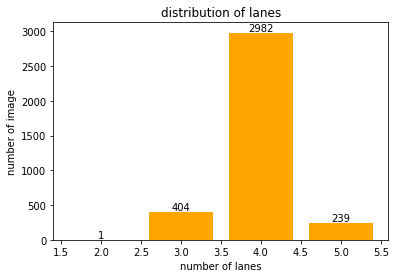

In [5]:
# 注意改变你这里的root_dir
root_dir = "E:/1/practice/data augument/train_set"

file_list = os.listdir(root_dir)
file_list = [item for item in file_list if item.endswith(".json")]
#dataset中存放每一条数据，也就是每一帧的标注
dataset = []
for name in file_list:
    path = os.path.join(root_dir, name)
    with open(path, encoding='utf-8') as f:
        for item in f.readlines():
            dataset.append(json.loads(item))

print("total number of image {}".format(len(dataset)))
#number_each_image存放没一副图片中标注的数量
number_each_image = []
for item in dataset:
    number_each_image.append(len(item['lanes']))
#统计每种数量的分布
result = {}
for item in number_each_image:
    if item not in result:
        result[item] = 1
    else:
        result[item] += 1
total_val = sum([i*result[i] for i in result])
print("total number of lane {}".format(total_val))
x = [2,3,4,5]
y = [result[i] for i in x]
graph = plt.bar(x, y, color="orange")
for b in graph:
    h = b.get_height()
    plt.text(b.get_x()+b.get_width()/2, h, '%d'%int(h),ha='center',va='bottom')
plt.title("distribution of lanes")
plt.xlabel("number of lanes")
plt.ylabel("number of image")
plt.show()

### Distribution Of Points

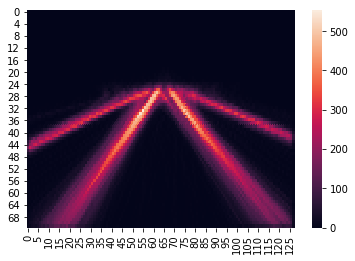

In [6]:
total_points = []
for item in dataset:
    lanes_points = [[(x, y) for (x, y) in zip(lane, item['h_samples']) if x >= 0] for lane in item["lanes"]]
    for lane in lanes_points:
        total_points.extend(lane)

point_heatmap = np.zeros((72, 128))
for point in total_points:
    point_heatmap[int(point[1]/10)][int(point[0]/10)]  += 1
    
sb.heatmap(point_heatmap)
plt.show()

### Data Augmentation

### pixel level 
* 亮度变化
* 对比度变化
* 锐化
* 颜色饱和度

In [7]:
def display_instance(image, lanes_points):
    img_vis = image.copy ()
    for lane in lanes_points:
        cv2.polylines (img_vis, np.int32 ([lane]), isClosed=False, color=(0, 255, 255), thickness=4)
    plt.imshow (img_vis[:, :, ::-1])
    plt.xticks ([])
    plt.yticks ([])
    plt.show ()

def display_augment_instance(image, aug_image, points, aug_points):
    img_vis = image.copy()
    for lane in points:
        cv2.polylines(img_vis, np.int32 ([lane]), isClosed=False, color=(0, 255, 255), thickness=4)
    aug_image_vis = aug_image.copy()
    for lane in aug_points:
        cv2.polylines(aug_image_vis, np.int32 ([lane]), isClosed=False, color=(0, 255, 255), thickness=4)
    plt.figure(figsize=(12,8))
    ax = plt.subplot(121)
    ax.imshow(img_vis[:, :, ::-1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("origin image")

    ax = plt.subplot(122)
    ax.imshow (aug_image_vis[:, :, ::-1])
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title("augmentation image")
    plt.show()
    
def filter_invalid_point(points, h, w):
    aug_points = []
    for lane in points:
        temp = []
        for point in lane:
            if point[0] in range(0, w) and point[1] in range(0, h):
                temp.append(point)
        aug_points.append(temp)
    return aug_points

#### Demo of origin image

{'lanes': [[-100, -100, -100, -100, 632, 625, 617, 609, 601, 594, 586, 578, 570, 563, 555, 547, 539, 532, 524, 516, 508, 501, 493, 485, 477, 469, 462, 454, 446, 438, 431, 423, 415, 407, 400, 392, 384, 376, 369, 361, 353, 345, 338, 330, 322, 314, 307, 299], [-100, -100, -100, -100, 719, 734, 748, 762, 777, 791, 805, 820, 834, 848, 863, 877, 891, 906, 920, 934, 949, 963, 978, 992, 1006, 1021, 1035, 1049, 1064, 1078, 1092, 1107, 1121, 1135, 1150, 1164, 1178, 1193, 1207, 1221, 1236, 1250, 1265, -100, -100, -100, -100, -100], [-100, -100, -100, -100, -100, 532, 503, 474, 445, 416, 387, 358, 329, 300, 271, 241, 212, 183, 154, 125, 96, 67, 38, 9, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100], [-100, -100, -100, 781, 822, 862, 903, 944, 984, 1025, 1066, 1107, 1147, 1188, 1229, 1269, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -1

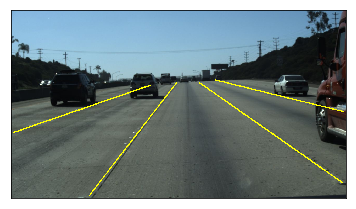

In [16]:
root_dir = "E:/1/practice/data augument/train_set"
file_list = os.listdir(root_dir)
file_list = [item for item in file_list if item.endswith(".json")]

dataset = []
for name in file_list:
    path = os.path.join(root_dir, name)
    with open(path, encoding='utf-8') as f:
        for item in f.readlines():
            dataset.append(json.loads(item))

id_index = random.choice(dataset)
for i in range(len(dataset)):
    id_index = dataset[i]
    if(os.path.exists(os.path.join(root_dir, id_index["raw_file"]))):
        break
print(id_index)
# demo one instance
image = cv2.imread(os.path.join(root_dir, id_index["raw_file"]))
lanes_points = [[(x, y) for (x, y) in zip(lane, id_index['h_samples']) if x >= 0] for lane in id_index["lanes"]]
print(lanes_points)
display_instance(image, lanes_points)

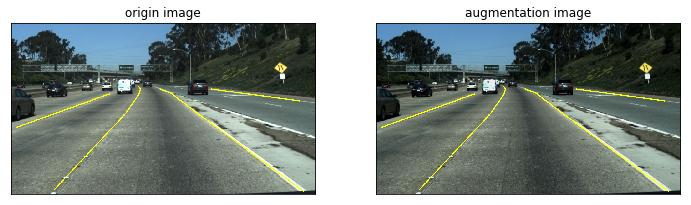

In [8]:
def adjust_light(image):
    aug_image = image.copy()
    aug_image = aug_image.astype(np.int32)
    val = np.random.randint(-40, 40)
    
    aug_image += val
    aug_image = np.maximum(np.minimum(aug_image, 255), 0)
    return aug_image

aug_image = adjust_light(image)
display_augment_instance(image, aug_image, lanes_points, lanes_points)

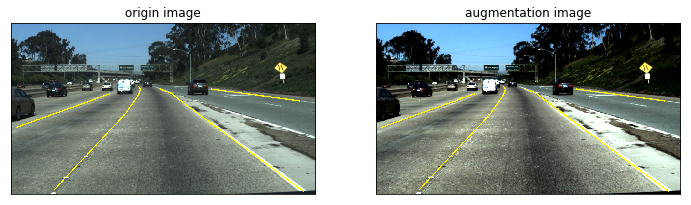

In [20]:
def adjust_contrast(image):
    aug_image = image.copy()
    aug_image = aug_image.astype(np.float32)
    mean_img = np.mean(aug_image, axis=(0,1))
    coeff = random.uniform(0.5, 3)
    aug_image = (aug_image-mean_img) * coeff
    aug_image += mean_img
    aug_image = aug_image.astype(np.int32)
    aug_image = np.maximum(np.minimum(aug_image, 255), 0)
    return aug_image

aug_image = adjust_contrast(image)
display_augment_instance(image, aug_image, lanes_points, lanes_points)

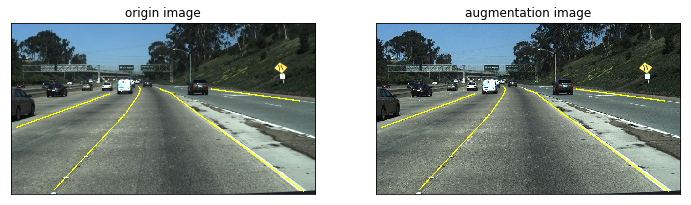

In [10]:
def sharp_image(image):
    aug_image = image.copy()
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]], np.float32)
    aug_image = cv2.filter2D(aug_image, -1, kernel=kernel)
    return aug_image

aug_image = sharp_image(image)
display_augment_instance(image, aug_image, lanes_points, lanes_points)

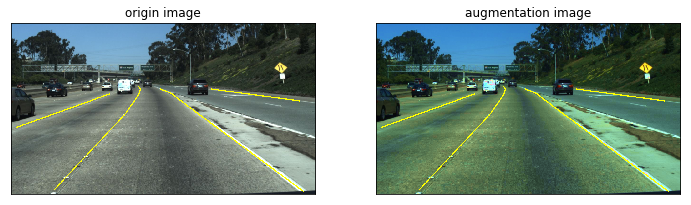

In [28]:
def adjust_saturation(image):
    aug_image = image.copy()
    aug_image = aug_image.astype(np.float32)
    hsv_image = cv2.cvtColor(aug_image,cv2.COLOR_BGR2HSV)
    hsv_image[:, :, 1] += random.uniform(-0.5, 0.5)
    hsv_image[:, :, 1] = np.clip(hsv_image[:,:,1], 0, 1)
    aug_image = cv2.cvtColor(hsv_image,cv2.COLOR_HSV2BGR)
    aug_image = aug_image.astype(np.int32)
    aug_image = np.maximum(np.minimum(aug_image, 255), 0)
    return aug_image

aug_image = adjust_saturation(image)
display_augment_instance(image, aug_image, lanes_points, lanes_points)

#### Geometric Augmentation
标签与图像同步变化．
* 水平翻转
* 随机放缩裁剪并填充
* 随机位移
* 随机旋转

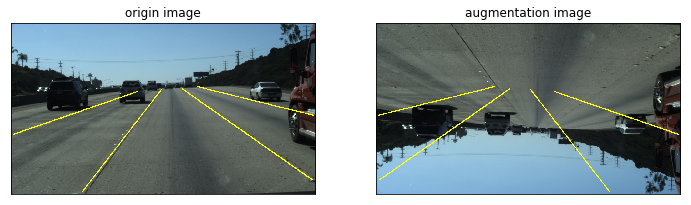

In [17]:
def horizon_flip(image, points):
    aug_image = image.copy()
    aug_points = []
    #根据图像宽度左右翻转
    aug_image = aug_image[:, ::-1,:]
    #aug_image = aug_image[::-1, :,:]
    h,w,_= aug_image.shape
    for lane in points:
        temp = []
        for point in lane:
            temp.append((w-1-point[0], point[1]))
        aug_points.append(temp)
            
    return aug_image, aug_points

aug_image, aug_point = horizon_flip(image, lanes_points)
display_augment_instance(image, aug_image, lanes_points, aug_point)

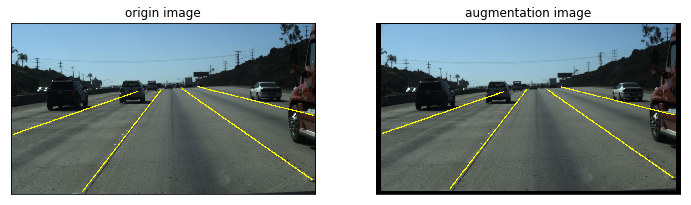

In [19]:
def random_scale_crop_pad(image, points):
    scale = random.uniform(0.7, 1.5)
    h,w,_ = image.shape
    aug_image = image.copy()
    aug_image = cv2.resize(aug_image, (int(scale*w), int(scale*h)))
    aug_points = [] 
    if(scale<1.0):
        new_h, new_w, _ = aug_image.shape
        pre_h_pad = int((h-new_h)/2)
        pre_w_pad = int((w-new_w)/2)
        pad_list = [[pre_h_pad, h-new_h-pre_h_pad], [pre_w_pad, w-new_w-pre_w_pad], [0, 0]]
        aug_image = np.pad(aug_image, pad_list, mode="constant")
        for lane in points:
            temp = []
            for point in lane:
                temp.append((int(point[0]*scale+pre_w_pad), int(point[1]*scale+pre_h_pad)))
            aug_points.append(temp)
        
    if(scale>1.0):
        new_h, new_w, _ = aug_image.shape
        pre_h_crop = int((new_h - h)/2)
        pre_w_crop = int((new_w - w)/2)
        post_h_crop = h + pre_h_crop
        post_w_crop = w + pre_w_crop
        aug_image = aug_image[pre_h_crop:post_h_crop, pre_w_crop:post_w_crop]
        for lane in points:
            temp = []
            for point in lane:
                temp.append((int(point[0]*scale-pre_w_crop), int(point[1]*scale-pre_h_crop)))
            aug_points.append(temp)
    aug_points = filter_invalid_point(aug_points,h,w)
    return aug_image, aug_points


aug_image, aug_point = random_scale_crop_pad(image, lanes_points)
display_augment_instance(image, aug_image, lanes_points, aug_point)

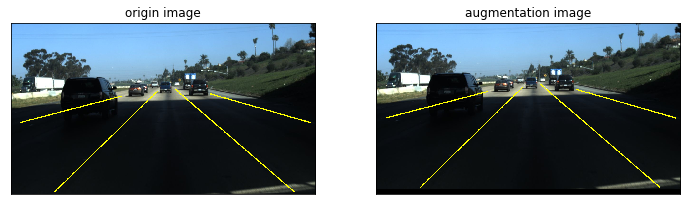

In [12]:
def random_shift(image, points):
    aug_image = image.copy()
    h,w, _= aug_image.shape
    aug_image = np.pad(aug_image, [[20,20], [20, 20], [0,0]], mode="constant")
    x = np.random.randint(0, 20*2+1)
    y = np.random.randint(0, 20*2+1)
    aug_image = aug_image[y:y+h, x:x+w]
    aug_points = []
    for lane in points:
            temp = []
            for point in lane:
                temp.append((int(point[0]+20-x), int(point[1]+20-y)))
            aug_points.append(temp)
    return aug_image, aug_points

aug_image, aug_point = random_shift(image, lanes_points)
display_augment_instance(image, aug_image, lanes_points, aug_point)

# 请实现 random_rotate,角度变化在-15到15度之间（需要注意的是几何变换，一般图像和标签一起变换）

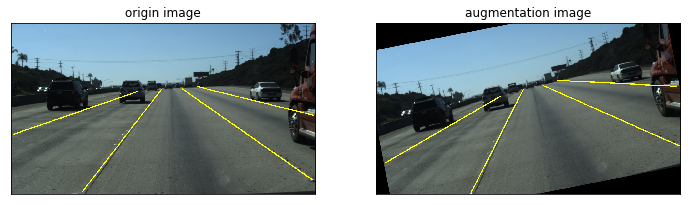

In [25]:
def random_rotate(image, points):
    aug_image = image.copy()
    h,w,_ = aug_image.shape
    c_h,c_w = int((h-1)/2),int((w-1)/2)
    random_angle = np.random.randint(-20,20)
    #计算旋转矩阵，三个参数，旋转中心，旋转角度，图像缩放比例
    M = cv2.getRotationMatrix2D((c_w,c_h),random_angle,1)
    aug_image = cv2.warpAffine(aug_image,M,(w,h))
    angle_rad = (np.pi*random_angle)/180.0
    c_h = h-c_h
    aug_points = []
    for lane in points:
        temp = []
        for point in lane:
            new_h = h-point[1]
            rotate_w = c_w + np.cos(angle_rad)*(point[0]-c_w)-np.sin(angle_rad)*(new_h-c_h)
            rotate_h = c_h + np.sin(angle_rad)*(point[0]-c_w)+np.cos(angle_rad)*(new_h-c_h)
            temp.append((int(rotate_w), int(h-rotate_h)))
        aug_points.append(temp)
    return aug_image, aug_points

aug_image, aug_point = random_rotate(image, lanes_points)
display_augment_instance(image, aug_image, lanes_points, aug_point)

##  More thing
* 除了上面所展示数据增强方法，还有[cutout](https://arxiv.org/abs/1708.04552)；[mixup: Beyond Empirical Risk Minimization](https://arxiv.org/abs/1710.09412)；利用GAN来做数据增强的方法[AugGAN: Cross Domain Adaptation with GAN-based Data Augmentation](http://openaccess.thecvf.com/content_ECCV_2018/papers/Sheng-Wei_Huang_AugGAN_Cross_Domain_ECCV_2018_paper.pdf)
* 一般来说，合理的数据增强会使模型性能更加；但是由于数据标注误差原因，不一定所有数据增强方法都有用．
* 目前研究发现，对于不同的任务与不同的数据集，各个数据增强方法的作用效率不一样，具体见[AutoAugment:
Learning Augmentation Strategies from Data](https://arxiv.org/pdf/1805.09501.pdf)
* 在开始尝试时，尽量使用与别人相同的预处理和数据增强方法，例如在lane detection中一般使用随机翻转，随机旋转，随机裁剪的数据增强方法．

### Albumentations

In [32]:
import albumentations as albu

In [38]:
points = []
for item in lanes_points:
    points.extend(item)

In [41]:
def vis_points(image, points, diameter=15):
    im = image.copy()

    for (x, y) in points:
        cv2.circle(im, (int(x), int(y)), diameter, (0, 255, 0), -1)

    plt.imshow(im)
    plt.show()
    

def create_transformer(transformations):
    return albu.Compose(transformations, p=1, 
                        keypoint_params=albu.KeypointParams(format='xy'))(image=image, keypoints=points)

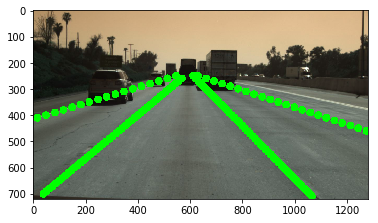

In [43]:
transformed = create_transformer([albu.HorizontalFlip(p=1)])

keypoints = transformed['keypoints']
im = transformed['image']
vis_points(im, keypoints)

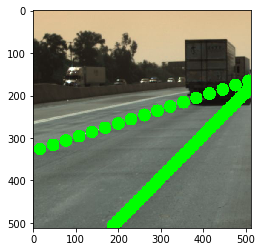

In [44]:
transformed = create_transformer([albu.RandomCrop(width=512, height=512, p=1)])

keypoints = transformed['keypoints']
im = transformed['image']
vis_points(im, keypoints)

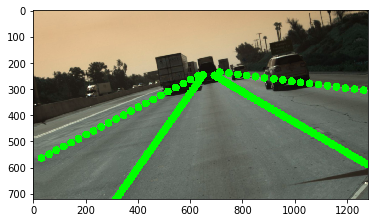

In [46]:
transformed = create_transformer([albu.Rotate(p=1)])

keypoints = transformed['keypoints']
im = transformed['image']
vis_points(im, keypoints)

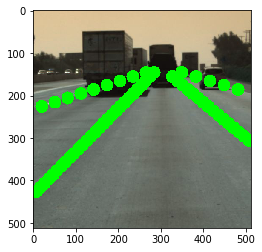

In [47]:
transformed = create_transformer([albu.CenterCrop(height=512, width=512, p=1)])

keypoints = transformed['keypoints']
im = transformed['image']
vis_points(im, keypoints)

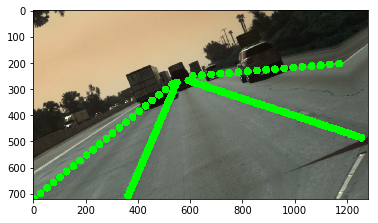

In [48]:
transformed = create_transformer([albu.ShiftScaleRotate(p=1)])

keypoints = transformed['keypoints']
im = transformed['image']

vis_points(im, keypoints)

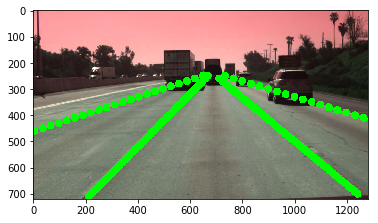

In [49]:
transformed = create_transformer([albu.RandomSizedCrop(min_max_height=(256, 1025), height=512, width=512, p=0.5),
                            albu.HorizontalFlip(p=0.5),
                            albu.OneOf([albu.HueSaturationValue(p=0.5), 
                                        albu.RGBShift(p=0.7)], p=1),                          
                            albu.RandomBrightnessContrast(p=0.5)])

keypoints = transformed['keypoints']
im = transformed['image']


vis_points(im, keypoints)